In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import permutations
from groupy import *

In [4]:
def pmId_Frechet_SDP(X):
    Z = GW_SDP(X)
    evals, evecs = np.linalg.eig(Z)
    eps_sdp = np.sign(evecs[:,0])

    # apply optimal g_i to x_i
    Ysdp = eps_sdp*X
    usdp = np.mean(Ysdp, axis=1)
    
    return usdp

def pmId_Frechet_Spectral(X):
    # round top eigenvector of Gram matrix
    eps = np.sign(np.linalg.eigh(X.T @ X)[1][:,-1])

    # apply optimal g_i to x_i
    Yspec = eps*X
    uspec = np.mean(Yspec, axis= 1)
    return uspec

In [5]:
d  = 2

# cluster generation parameters
n1 = 15
n2 = 15
n3 = 15

u1 = np.array([0,1]).reshape(-1,1)
u2 = np.array([1,0]).reshape(-1,1)
u3 = np.array([1,1]).reshape(-1,1)
s1 = .5
s2 = .3
s3 = .2
X  = np.hstack([np.random.normal(loc = u1, scale=s1, size = [d,n1]),
                np.random.normal(loc = u2, scale=s2, size = [d,n2]),
                np.random.normal(loc = u3, scale=s3, size = [d,n3])])

truth = np.hstack([u1,u2,u3])
# generate some noisy initial guess
start = truth + np.random.normal(size = (d,3), scale = s3)
labels = np.hstack([np.zeros(n1, dtype='int'), np.ones(n2, dtype='int'), 2*np.ones(n3, dtype='int')])


G = CustomFrechet_GroupAction(pmId, d, pmId_Frechet_SDP)
Y = G.randomize_reps(X)

# Generated Data

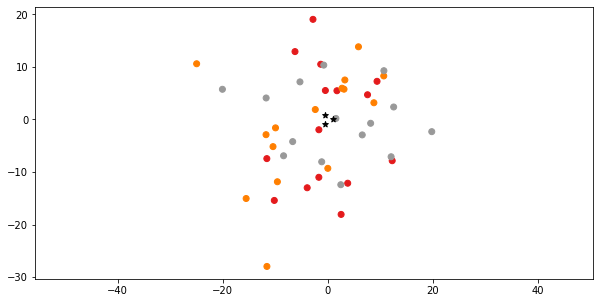

In [30]:
C, classes = G.kmeans_sdp(X, 3, 'iterative')

fig = plt.figure(figsize = (10,5))
plt.axis('equal')
plt.scatter(X[0,:], X[1,:], c = labels, cmap = 'Set1')
plt.scatter(truth[0,:], truth[1,:], c = 'black', marker='*')
plt.show()

# Generated Data with Scrambed Group Representation (Input Data to kMeans)

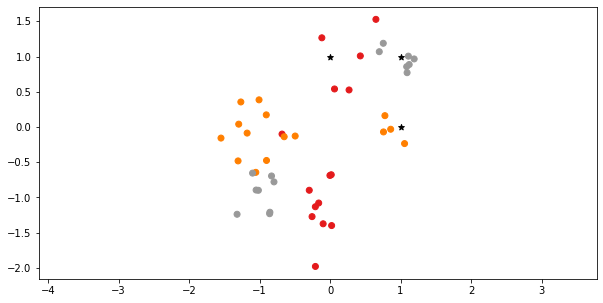

In [5]:
fig = plt.figure(figsize = (10,5))
plt.axis('equal')
plt.scatter(Y[0,:], Y[1,:], c = labels, cmap = 'Set1')
plt.scatter(truth[0,:], truth[1,:], c = 'black', marker='*')
plt.show()

# kMeans SDP with Quotient Distance

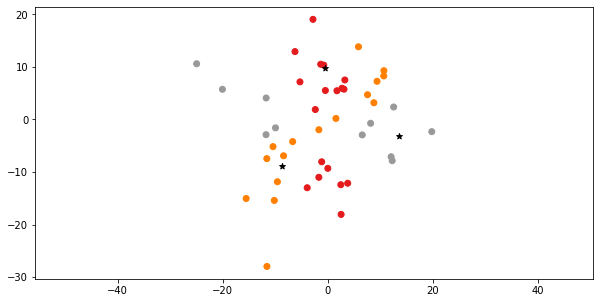

In [31]:
# "solver" just means what is used to compute the means at the end
C, classes = G.kmeans_sdp(X, 3, solver = 'exact')

fig = plt.figure(figsize = (10,5))
plt.axis('equal')
plt.scatter(X[0,:], X[1,:], c = classes, cmap='Set1')
plt.scatter(C[0,:], C[1,:], color = 'black', marker='*')
plt.show()

# Lloyds exact Frechet Mean Computation

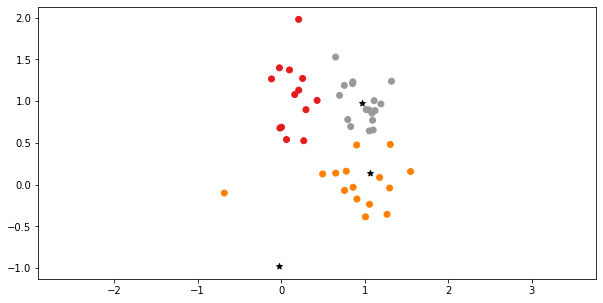

In [7]:
C, classes = G.kmeans(X, 3, init=truth, solver = 'exact')


fig = plt.figure(figsize = (10,5))
plt.axis('equal')

plt.scatter(X[0,:], X[1,:], c = classes, cmap= 'Set1')
plt.scatter(C[0,:], C[1,:], color = 'black', marker='*')
plt.show()

# Lloyds with Gradient Descent

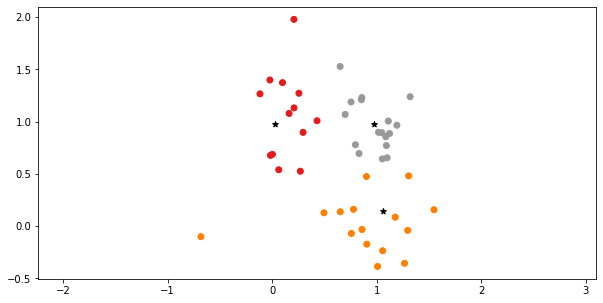

In [8]:
C, classes = G.kmeans(X, 3, init=truth, solver = 'iterative')


fig = plt.figure(figsize = (10,5))
plt.axis('equal')
plt.scatter(X[0,:], X[1,:], c = classes, cmap= 'Set1')
plt.scatter(C[0,:], C[1,:], color = 'black', marker='*')
plt.show()

# Lloyds with SDP for +-Id

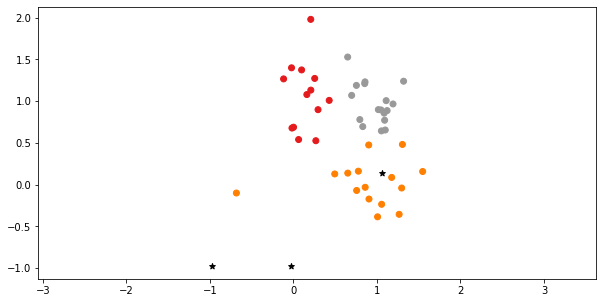

In [9]:
C, classes = G.kmeans(X, 3, init=truth, solver = 'custom')

fig = plt.figure(figsize = (10,5))
plt.axis('equal')
plt.scatter(X[0,:], X[1,:], c = classes, cmap='Set1')
plt.scatter(C[0,:], C[1,:], color = 'black', marker='*')
plt.show()

# Lloyds with Spectral Relaxation for +-Id

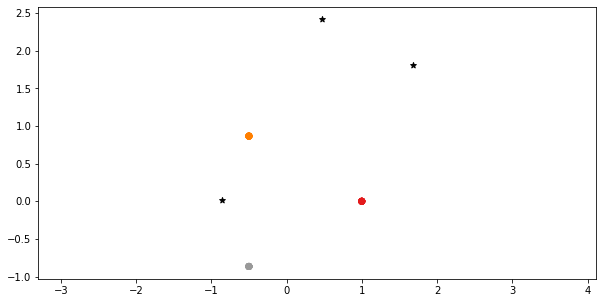

In [34]:
G2 = CustomFrechet_GroupAction(pmId, d, pmId_Frechet_Spectral)
C, classes = G2.kmeans(X, 3, init=truth, solver = 'custom')

fig = plt.figure(figsize = (10,5))
plt.axis('equal')
plt.scatter(X[0,:], X[1,:], c = classes, cmap='Set1')
plt.scatter(init_centers[0,:], init_centers[1,:], color = 'black', marker='*')
plt.show()

# Accuracy Comparisons

In [35]:
d  = 2
# cluster generation parameters
n1 = 10
n2 = 10
n3 = 10
n = n1+ n2+ n3

u1 = np.array([1,0]).reshape(-1,1)
u2 = np.array([-1/2,np.sqrt(3)/2]).reshape(-1,1)
u3 = np.array([-1/2,-np.sqrt(3)/2]).reshape(-1,1)
truth = np.hstack([u1,u2,u3])
labels = np.hstack([np.zeros(n1, dtype='int'), np.ones(n2, dtype='int'), 2*np.ones(n3, dtype='int')])

G = CustomFrechet_GroupAction(pmId, d, pmId_Frechet_SDP)
G2 = CustomFrechet_GroupAction(pmId, d, pmId_Frechet_Spectral)

ntrials = 50
n_sigma = 20
sigmas = np.linspace(0, 1, n_sigma)

error_lloyd_exact = np.zeros(n_sigma)
error_lloyd_iterative = np.zeros(n_sigma)
error_lloyd_sdp = np.zeros(n_sigma)
error_lloyd_spectral = np.zeros(n_sigma)
error_sdp = np.zeros(n_sigma)

init_centers = np.random.normal(size = (d,3))

for i, s in enumerate(sigmas):
    print(f"sigma {s}", end = '\r')
    for trial in range(ntrials):
        X  = G.randomize_reps(np.hstack([np.random.normal(loc = u1, scale=s, size = [d,n1]),
                                            np.random.normal(loc = u2, scale=s, size = [d,n2]),
                                            np.random.normal(loc = u3, scale=s, size = [d,n3])]))
        # choosing random data pts for initial centroids to ensure something is always in every cluster
        
        C, classes = G.kmeans_sdp(X, 3, solver = 'iterative')
        error_sdp[i] += 1-max((classes == np.array(p)[labels]).mean() for p in permutations(range(3)))

        C, classes = G.kmeans(X, 3, solver = 'exact')
        error_lloyd_exact[i] += 1-max((classes == np.array(p)[labels]).mean() for p in permutations(range(3)))

        C, classes = G.kmeans(X, 3, solver = 'iterative') 
        error_lloyd_iterative[i] += 1-max((classes == np.array(p)[labels]).mean() for p in permutations(range(3)))
        
        C, classes = G.kmeans(X, 3, solver = 'custom')
        error_lloyd_sdp[i] += 1-max((classes == np.array(p)[labels]).mean() for p in permutations(range(3)))
        
        C, classes = G2.kmeans(X, 3, solver = 'custom')
        error_lloyd_spectral[i] += 1-max((classes == np.array(p)[labels]).mean() for p in permutations(range(3)))
    # get averages
    error_lloyd_exact[i] /= ntrials
    error_lloyd_iterative[i] /= ntrials
    error_lloyd_sdp[i] /= ntrials
    error_lloyd_spectral[i] /= ntrials
    error_sdp[i] /= ntrials

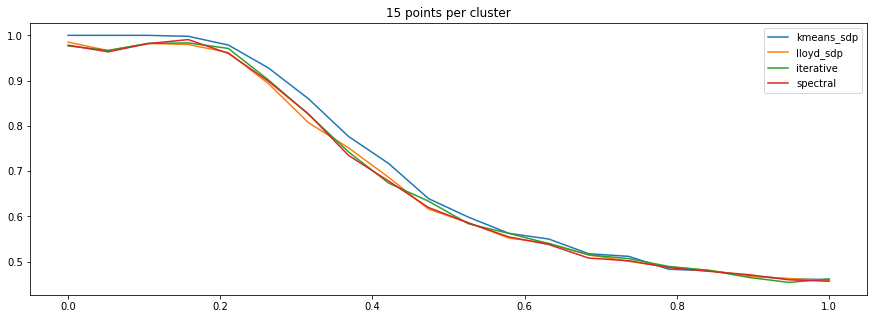

In [18]:
fig = plt.figure(figsize = (15,5))

plt.title("15 points per cluster")
plt.plot(sigmas, 1-error_sdp, label = 'kmeans_sdp')
plt.plot(sigmas, 1-error_lloyd_sdp, label = 'lloyd_sdp')
plt.plot(sigmas, 1-error_lloyd_iterative, label = 'iterative')
plt.plot(sigmas, 1-error_lloyd_spectral, label = 'spectral')
plt.legend()

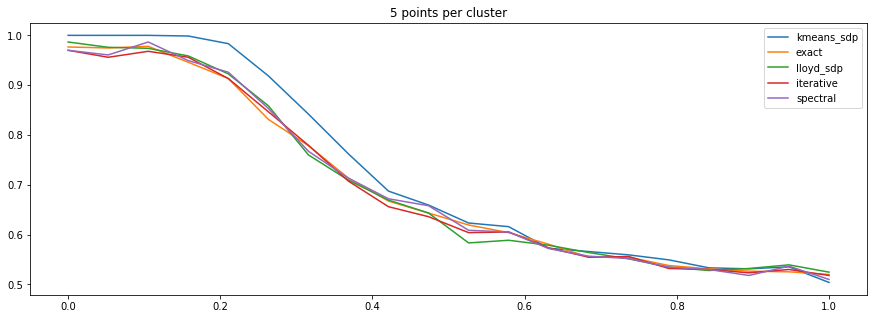

In [12]:
fig = plt.figure(figsize = (15,5))

plt.title("5 points per cluster")
plt.plot(sigmas, 1-error_sdp, label = 'kmeans_sdp')
plt.plot(sigmas, 1-error_lloyd_exact, label = 'exact')
plt.plot(sigmas, 1-error_lloyd_sdp, label = 'lloyd_sdp')
plt.plot(sigmas, 1-error_lloyd_iterative, label = 'iterative')
plt.plot(sigmas, 1-error_lloyd_spectral, label = 'spectral')
plt.legend()

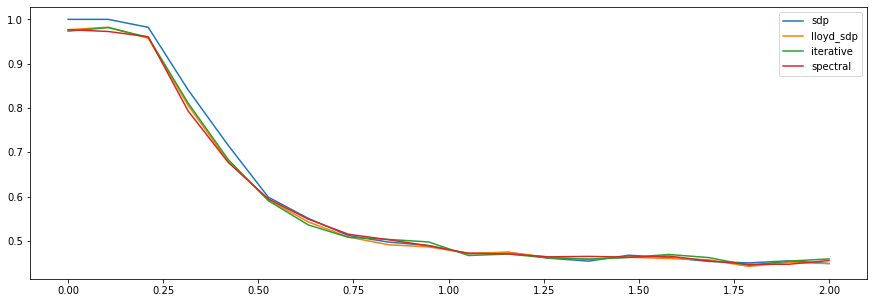

In [9]:
fig = plt.figure(figsize = (15,5))

plt.plot(sigmas, 1-error_sdp, label = 'kmeans_sdp')
plt.plot(sigmas, 1-error_lloyd_sdp, label = 'lloyd_sdp')
plt.plot(sigmas, 1-error_lloyd_iterative, label = 'iterative')
plt.plot(sigmas, 1-error_lloyd_spectral, label = 'spectral')
plt.legend()

# Timing

In [ ]:
# fixed data dimension and noise
d = 2
sigma = 0.3

# cluster centers
u1 = np.array([1,0]).reshape(-1,1)
u2 = np.array([-1/2,np.sqrt(3)/2]).reshape(-1,1)
u3 = np.array([-1/2,-np.sqrt(3)/2]).reshape(-1,1)
truth = np.hstack([u1, u2, u3])

# number of trials per setting
ntrials = 10

# different per‐cluster sizes to sweep over
n_vals = np.arange(1,15,2)

# preallocate timing arrays
time_lloyd_exact     = np.zeros(len(n_vals))
time_lloyd_iterative = np.zeros(len(n_vals))
time_lloyd_sdp       = np.zeros(len(n_vals))
time_lloyd_spectral  = np.zeros(len(n_vals))
time_sdp             = np.zeros(len(n_vals))

# group action objects (already configured)
G  = CustomFrechet_GroupAction(pmId, d, pmId_Frechet_SDP)
G2 = CustomFrechet_GroupAction(pmId, d, pmId_Frechet_Spectral)

for i, n_i in enumerate(n_vals):
    print(f"n_i = {n_i}", end = '\r')
    # total number of points
    n1 = n2 = n3 = n_i
    n = n1 + n2 + n3

    # accumulate runtime across trials
    t_exact = t_iter = t_sdpinit = t_spec = t_direct = 0.0

    for trial in range(ntrials):
        # generate data
        X = np.hstack([
            np.random.normal(loc=u1, scale=sigma, size=(d,n1)),
            np.random.normal(loc=u2, scale=sigma, size=(d,n2)),
            np.random.normal(loc=u3, scale=sigma, size=(d,n3))
        ])
        X = G.randomize_reps(X)   # whatever preprocessing you apply

        # 1) direct SDP
        t0 = time.perf_counter()
        _C, _cls = G.kmeans_sdp(X, 3, solver='iterative')
        t_direct += time.perf_counter() - t0

        # 2) Lloyd exact
        t0 = time.perf_counter()
        _C, _cls = G.kmeans(X, 3, solver='exact')
        t_exact += time.perf_counter() - t0

        # 3) Lloyd iterative
        t0 = time.perf_counter()
        _C, _cls = G.kmeans(X, 3, solver='iterative')
        t_iter += time.perf_counter() - t0

        # 4) Lloyd + SDP init
        t0 = time.perf_counter()
        _C, _cls = G.kmeans(X, 3, solver='custom')
        t_sdpinit += time.perf_counter() - t0

        # 5) Lloyd + Spectral init
        t0 = time.perf_counter()
        _C, _cls = G2.kmeans(X, 3, solver='custom')
        t_spec += time.perf_counter() - t0

    # average over trials
    time_sdp[i]             = t_direct / ntrials
    time_lloyd_exact[i]     = t_exact  / ntrials
    time_lloyd_iterative[i] = t_iter   / ntrials
    time_lloyd_sdp[i]       = t_sdpinit/ ntrials
    time_lloyd_spectral[i]  = t_spec   / ntrials

In [ ]:
# Plotting
plt.figure(figsize=(15,5))
plt.plot(n_vals, time_lloyd_exact,     marker='o', label='Lloyd (exact)')
plt.plot(n_vals, time_lloyd_iterative, marker='s', label='Lloyd (iterative)')
plt.plot(n_vals, time_lloyd_sdp,       marker='^', label='Lloyd + SDP')
plt.plot(n_vals, time_lloyd_spectral,  marker='d', label='Lloyd + Spectral')
plt.plot(n_vals, time_sdp,             marker='x', label='Direct SDP')
plt.xlabel('Cluster Size')
plt.ylabel('Average Runtime (s)')
plt.title('Clustering Runtimes vs. Cluster Size (σ=0.3)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()